# Steps for Text Generation
- first preprocess data
- second make training sequances dataset by [seq] -> next char as lable
- make this pairs
- apply char embedding
- train LSTM model but it may a problem how to handle output from first seq as input for next sequance in lstm
- firstful we try with const seq_lenth -> after const number of character generate one char in this time its=15
- train model
- test model


In [1]:
!pip install -U wikipedia
import numpy as np
import wikipedia as wiki
import spacy
import re
import tqdm
import tensorflow
from tensorflow.keras.layers import *
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

  Preparing metadata (setup.py) ... done
  Created wheel for wikipedia: filename=wikipedia-1.4.0-py3-none-any.whl size=11678 sha256=56eb65f44878ca3124dbb6fe1475f3ad7d12d3cfc1bce785e02a810aea7f2644
  Stored in directory: /root/.cache/pip/wheels/5e/b6/c5/93f3dec388ae76edc830cb42901bb0232504dfc0df02fc50de
Successfully built wikipedia


2024-05-12 23:30:22.540093: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-05-12 23:30:22.540194: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-05-12 23:30:22.674516: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


# Preprocessing

In [2]:
def process_text(document):
      nlp = spacy.load('en_core_web_sm')
      stopwords = nlp.Defaults.stop_words
      document = re.sub(r'\s+', ' ', document, flags=re.I)
      document = re.sub(r'\W', ' ', str(document))
      document = re.sub(r'_', ' ', str(document))
      document = re.sub(r'\s+[a-zA-Z]\s+', ' ', document)
      document = document.lower()
      document = re.sub(r'\s+', ' ', document, flags=re.I)
      doc_spacy = nlp(document)
      lemma_txt = ["".join(token.lemma_) for token in tqdm.tqdm(doc_spacy)]
      lemma_no_stop_txt = [word for word in lemma_txt if word not in stopwords]
      lemma_no_stop_txt = [word for word in lemma_no_stop_txt if len(word) > 3]
      clean_txt = ' '.join(lemma_no_stop_txt)
      clean_sents_list = [x for x in nlp(clean_txt).sents]
      return clean_sents_list, clean_txt, lemma_no_stop_txt

# Collect  Data From wikipedia and Arxiv research papers

In [3]:
# Download data (replace with your data acquisition method)
wiki.set_lang('en')

wiki_obj = wiki.page(wiki.search(['Large Language Models deep learning ', 'newest Large Language Models deep learning', 'attention mechanism ', 'transformers in Deep learning']))
data = wiki_obj.content
clean_sents_list, data_sents, data_txt = process_text(data)


100%|██████████| 2134/2134 [00:00<00:00, 519269.29it/s]


In [4]:
data_sents

'generative train transformer type large language model prominent framework generative artificial intelligence artificial neural network natural language processing task base transformer architecture train large data unlabelled text able generate novel human like content 2023 characteristic refer broadly introduce 2018 openai openai release influential foundation model sequentially number comprise series significantly capable previous increase size number trainable parameter train recent release march 2023 model basis task specific system include model fine tune instruction follow turn power chatgpt chatbot service term description model develop example foundation model include series model create eleutherai seven model create cerebra 2023 company different industry develop task specific respective field salesforce einsteingpt bloomberg bloomberggpt finance history initial development generative pretraine long establish concept machine learning application originally form semi supervis

In [5]:
# [token_sent.text for token_sent in clean_sents_list][1]

In [6]:
!pip install arxiv

  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 81.1/81.1 kB 3.0 MB/s eta 0:00:00
  Created wheel for sgmllib3k: filename=sgmllib3k-1.0.0-py3-none-any.whl size=6048 sha256=7ef0ad0a62bc87d97ac6f2859d9ad7aa4dd0b2338257ed189c48033a1e2e2ec4
  Stored in directory: /root/.cache/pip/wheels/f0/69/93/a47e9d621be168e9e33c7ce60524393c0b92ae83cf6c6e89c5
Successfully built sgmllib3k


In [7]:
import arxiv

# Search for articles related to "Large Language Models" (LLMs)
llm_search = arxiv.Search(query=['Large Language Models deep learning '], max_results=100)
llm_results = list(llm_search.results())

llm_papers = ""

print("Articles related to Large Language Models:")
for result in llm_results:
    llm_papers += f"Title: {result.title}\n\nAbstract: {result.summary}\n\n"


transformer_search = arxiv.Search(query="Transformers in deep learning", max_results=100)
transformer_results = list(transformer_search.results())

transformer_papers = ""

print("\nArticles related to Transformers in deep learning:")
for result in transformer_results:
    transformer_papers += f"{result.title}Abstract: {result.summary}"

all_papers = llm_papers + transformer_papers
# print(all_papers)
data=process_text(all_papers)[1]+ ' '+ data_sents

Articles related to Large Language Models:

Articles related to Transformers in deep learning:


100%|██████████| 17712/17712 [00:00<00:00, 532194.14it/s]


In [8]:
data

'deep transformation model tackle complex regression problem neural network base transformation modelsabstract present deep transformation model probabilistic regression deep learning know outstandingly accurate prediction complex datum regression task predominantly predict single number ignore deterministic character task especially crucial decision base prediction like medical application essential quantify prediction uncertainty present deep learn transformation model estimate conditional probability distribution thorough capture uncertainty outcome combine idea statistical transformation model likely transformation recent transformation model deep learning normalizing flow predict complex outcome distribution core method parameterized transformation function train usual maximum likelihood framework gradient descent method combine exist deep learning architecture small machine learn benchmark dataset report state performance dataset partly outperform method work complex input datum 

In [9]:
def get_training_and_testing_sets(file_list):
    split = 0.7
    split_index = int(np.floor(len(file_list) * split))
    training = file_list
    testing = file_list[split_index:]
    return training, testing

In [10]:
train_data,test_data=get_training_and_testing_sets(data)

In [11]:
len(test_data)/len(data)

0.30000512899420423

For training

In [12]:
clean_sents_list, x_train_sents, x_train_clean_txt = process_text(train_data)

100%|██████████| 11562/11562 [00:00<00:00, 484896.94it/s]


For testing

In [13]:
clean_sents_list_testing, x_test_sents, x_test_clean_txt = process_text(test_data)

100%|██████████| 3508/3508 [00:00<00:00, 505935.58it/s]


# Creat Training pairs Char_Based_GEN_model

In [14]:
Seq_length=300
def create_dataset(text_data, seq_length=Seq_length):
  chars = sorted(list(set(text_data)))
  char_to_int = dict((c, i) for i, c in enumerate(chars))
  X_data = []
  y_data = []
  for i in range(0, len(text_data) - seq_length, 1):
    seq_in = text_data[i:i + seq_length]
    seq_out = text_data[i + seq_length]

    X_data.append([char_to_int[char] for char in seq_in])

    y_data.append(char_to_int[seq_out])

  return np.array(X_data),np.array(y_data),len(chars)


In [15]:
X,y,char_unique_size=create_dataset(x_train_sents,seq_length=15)
y=y.reshape(len(y),1)
x_catagorical=tensorflow.keras.utils.to_categorical(X)
y_catagorical=tensorflow.keras.utils.to_categorical(y)
y.shape

(96806, 1)

In [16]:
char_unique_size

38

# Char Based GEN Model

In [ ]:
model = tensorflow.keras.Sequential([
  Embedding(char_unique_size, 124),
#   Dropout(0.5),
  GRU(520, return_sequences=True),
  Bidirectional(layer=GRU(340, return_sequences=True,activation='tanh')),
  GlobalMaxPooling1D(),
  Dense(1024, activation='elu'),
  Dense(char_unique_size, activation='softmax'),
])

In [74]:
model_char_based_RNN=tensorflow.keras.Sequential([
  Embedding(char_unique_size, 124),
#   Dropout(0.5),
  Bidirectional(layer=SimpleRNN(520, return_sequences=True,activation='tanh')),
  Bidirectional(layer=SimpleRNN(340, return_sequences=True,activation='tanh')),
  GlobalMaxPooling1D(),
  Dense(1024, activation='elu'),
  Dense(char_unique_size, activation='softmax'),
])

In [19]:
model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [75]:
model_char_based_RNN.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])


In [21]:
history=model.fit(X,y,epochs=10,batch_size=100)

Epoch 1/10
969/969 ━━━━━━━━━━━━━━━━━━━━ 20s 15ms/step - accuracy: 0.3187 - loss: 2.2991
Epoch 2/10
969/969 ━━━━━━━━━━━━━━━━━━━━ 14s 15ms/step - accuracy: 0.5996 - loss: 1.3231
Epoch 3/10
969/969 ━━━━━━━━━━━━━━━━━━━━ 14s 15ms/step - accuracy: 0.6639 - loss: 1.0919
Epoch 4/10
969/969 ━━━━━━━━━━━━━━━━━━━━ 14s 15ms/step - accuracy: 0.7006 - loss: 0.9550
Epoch 5/10
969/969 ━━━━━━━━━━━━━━━━━━━━ 14s 15ms/step - accuracy: 0.7212 - loss: 0.8676
Epoch 6/10
969/969 ━━━━━━━━━━━━━━━━━━━━ 14s 15ms/step - accuracy: 0.7433 - loss: 0.7938
Epoch 7/10
969/969 ━━━━━━━━━━━━━━━━━━━━ 15s 15ms/step - accuracy: 0.7712 - loss: 0.7100
Epoch 8/10
969/969 ━━━━━━━━━━━━━━━━━━━━ 14s 15ms/step - accuracy: 0.7944 - loss: 0.6249
Epoch 9/10
969/969 ━━━━━━━━━━━━━━━━━━━━ 14s 15ms/step - accuracy: 0.8196 - loss: 0.5511
Epoch 10/10
969/969 ━━━━━━━━━━━━━━━━━━━━ 14s 15ms/step - accuracy: 0.8459 - loss: 0.4759


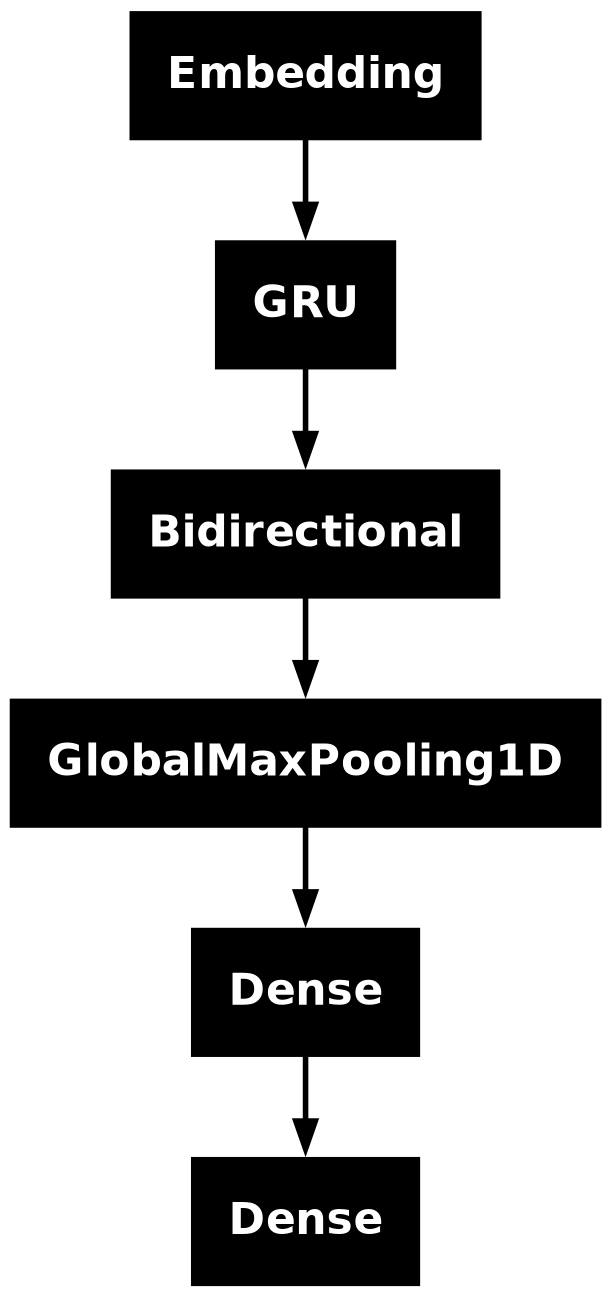

In [22]:
from tensorflow.keras.utils import plot_model
plot_model(model,'./GRU.png')

In [77]:
history_RNN=model_char_based_RNN.fit(X,y,epochs=10,batch_size=50)

Epoch 1/10
1937/1937 ━━━━━━━━━━━━━━━━━━━━ 25s 13ms/step - accuracy: 0.6839 - loss: 1.0035
Epoch 2/10
1937/1937 ━━━━━━━━━━━━━━━━━━━━ 25s 13ms/step - accuracy: 0.6900 - loss: 0.9783
Epoch 3/10
1937/1937 ━━━━━━━━━━━━━━━━━━━━ 25s 13ms/step - accuracy: 0.6886 - loss: 0.9745
Epoch 4/10
1937/1937 ━━━━━━━━━━━━━━━━━━━━ 25s 13ms/step - accuracy: 0.6927 - loss: 0.9661
Epoch 5/10
1937/1937 ━━━━━━━━━━━━━━━━━━━━ 25s 13ms/step - accuracy: 0.6974 - loss: 0.9568
Epoch 6/10
1937/1937 ━━━━━━━━━━━━━━━━━━━━ 25s 13ms/step - accuracy: 0.6936 - loss: 0.9641
Epoch 7/10
1937/1937 ━━━━━━━━━━━━━━━━━━━━ 25s 13ms/step - accuracy: 0.6969 - loss: 0.9530
Epoch 8/10
1937/1937 ━━━━━━━━━━━━━━━━━━━━ 25s 13ms/step - accuracy: 0.6968 - loss: 0.9583
Epoch 9/10
1937/1937 ━━━━━━━━━━━━━━━━━━━━ 25s 13ms/step - accuracy: 0.6978 - loss: 0.9532
Epoch 10/10
1937/1937 ━━━━━━━━━━━━━━━━━━━━ 25s 13ms/step - accuracy: 0.7017 - loss: 0.9307


In [78]:
import numpy as np

def test_prediction_random_char_based_model_gen(model, input_text=test_data, seq_length=Seq_length, max_length=10):
    max_length_char_pred = []
    all_text = input_text
    chars = [char for char in input_text]
    random_start_index = np.random.randint(0, len(chars) - seq_length)
    input_text = all_text[random_start_index:random_start_index + seq_length]

    if len(chars) < seq_length:
        print("Input text is too short for the specified sequence length.")
        return None
  
    unique_chars = sorted(list(set(chars)))
    char_to_int = {c: i for i, c in enumerate(unique_chars)}
    int_to_char = {i: c for i, c in enumerate(unique_chars)}

    for i in range(max_length):
        if i > 0:
            input_text = input_text[1:] + max_length_char_pred[-1]

        if len(input_text) < seq_length:
            print("Input text is too short for the specified sequence length.")
            break

        input_seq = [char_to_int[char] for char in input_text]
        input_seq = np.array(input_seq).reshape(1, seq_length)
        prediction = model.predict(input_seq)
        predicted_char = int_to_char[np.argmax(prediction)]
        max_length_char_pred.append(predicted_char)

    true_chars = ''.join(max_length_char_pred)
    print(f'true char is {true_chars}')
    return max_length_char_pred


# Eval

GRU

In [26]:
x_model_test,y_model_test,_=create_dataset(x_test_sents)

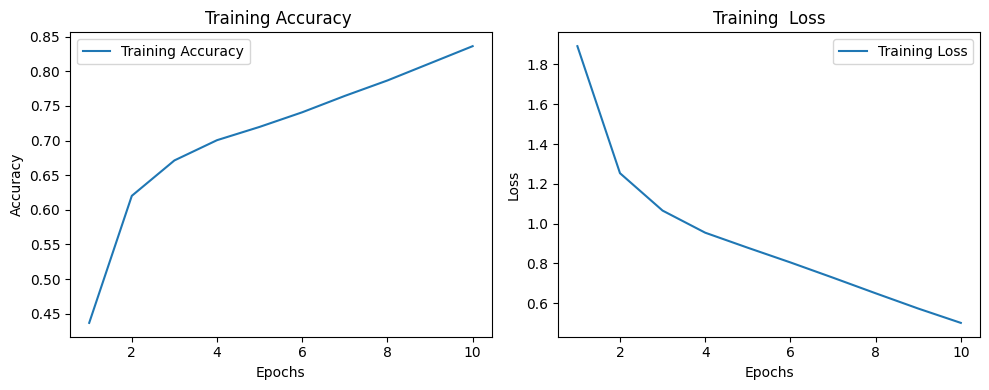

In [79]:
def plot_training_history(history):

    train_accuracy = history.history['accuracy']
#     val_accuracy = history.history['val_accuracy']
    train_loss = history.history['loss']
#     val_loss = history.history['val_loss']

    plt.figure(figsize=(10, 4))
    plt.subplot(1, 2, 1)
    plt.plot(range(1, len(train_accuracy) + 1), train_accuracy, label='Training Accuracy')
#     plt.plot(range(1, len(val_accuracy) + 1), val_accuracy, label='Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.title('Training Accuracy ')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(range(1, len(train_loss) + 1), train_loss, label='Training Loss')
#     plt.plot(range(1, len(val_loss) + 1), val_loss, label='Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Training  Loss')
    plt.legend()

    plt.tight_layout()
    plt.show()

# Assuming 'history' contains your training history
# Call the function to plot the training history
plot_training_history(history)


In [30]:
test_prediction_random_char_based_model_gen(model)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 257ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
true char is wuv tgrtgu


['w', 'u', 'v', ' ', 't', 'g', 'r', 't', 'g', 'u']

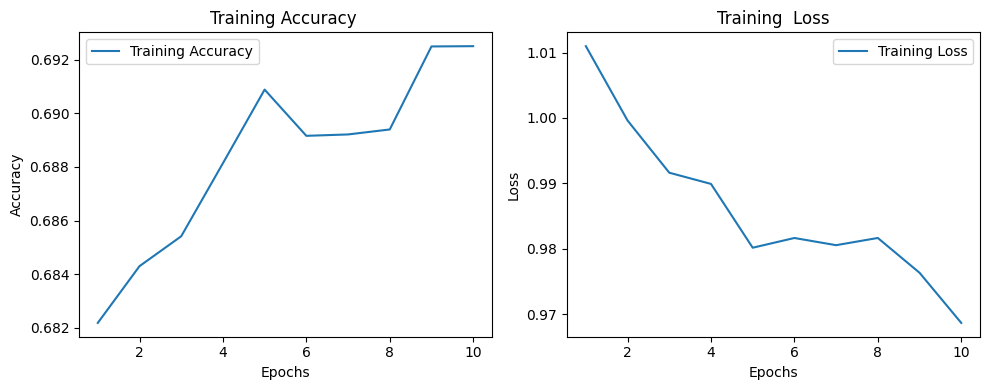

In [80]:
plot_training_history(history_RNN)

RNN

In [81]:
test_prediction_random_char_based_model_gen(model_char_based_RNN)

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 926ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
true char is  fggr ngct


[' ', 'f', 'g', 'g', 'r', ' ', 'n', 'g', 'c', 't']

#### Try to make all possible sequances

In [33]:
# its only try but take big running Duration
def create_dataset_all_sequences(text_data):
  chars = sorted(list(set(text_data)))
  char_to_int = dict((c, i) for i, c in enumerate(chars))
  X_data = []
  y_data = []

  # Loop through all starting positions in the text data
  for start_index in range(len(text_data)):
    # Loop through sequence lengths from 1 to a maximum length (can be adjusted)
    for seq_len in range(1, len(text_data) - start_index + 1):
      # Create input sequence
      input_seq = [char_to_int[char] for char in text_data[start_index:start_index + seq_len]]
      # Create target sequence (shifted by 1 character)
      target_seq = [char_to_int[char] for char in text_data[start_index + 1:start_index + seq_len + 1]]
      X_data.append(input_seq)
      y_data.append(target_seq)
  X_data = np.array(X_data)
  y_data = np.array(y_data)
  return X_data, y_data, char_to_int


# word Based generator training model

In [34]:
x_train_sents.split()

['deep',
 'transformation',
 'model',
 'tackle',
 'complex',
 'regression',
 'problem',
 'neural',
 'network',
 'base',
 'transformation',
 'modelsabstract',
 'present',
 'deep',
 'transformation',
 'model',
 'probabilistic',
 'regression',
 'deep',
 'learning',
 'know',
 'outstandingly',
 'accurate',
 'prediction',
 'complex',
 'datum',
 'regression',
 'task',
 'predominantly',
 'predict',
 'single',
 'number',
 'ignore',
 'deterministic',
 'character',
 'task',
 'especially',
 'crucial',
 'decision',
 'base',
 'prediction',
 'like',
 'medical',
 'application',
 'essential',
 'quantify',
 'prediction',
 'uncertainty',
 'present',
 'deep',
 'learn',
 'transformation',
 'model',
 'estimate',
 'conditional',
 'probability',
 'distribution',
 'thorough',
 'capture',
 'uncertainty',
 'outcome',
 'combine',
 'idea',
 'statistical',
 'transformation',
 'model',
 'likely',
 'transformation',
 'recent',
 'transformation',
 'model',
 'deep',
 'learn',
 'normalizing',
 'flow',
 'predict',
 'comp

In [35]:
import numpy as np

Words_Seq_length = 15

def create_dataset_word_based(text_data=x_train_sents, seq_length=Words_Seq_length):
    words = text_data.split()
    unique_words = sorted(set(words))
    word_to_int = {w: i for i, w in enumerate(unique_words)}
    int_to_word = {i: w for i, w in enumerate(unique_words)}

    X_data_words = []
    y_data_words = []
    for i in range(len(words) - seq_length):
        seq_in = words[i:i + seq_length]
        seq_out = words[i + seq_length]
        X_data_words.append([word_to_int[word] for word in seq_in])
        y_data_words.append(word_to_int[seq_out])
#     z=[int_to_word[word]for word in X_data_words[0]]
#     print(z)
    return np.array(X_data_words), np.array(y_data_words), len(unique_words)


In [36]:
X_wordSeq_training,Y_wordSEQ_training,UNique_words_len=create_dataset_word_based()

In [37]:
model_word_generation = tensorflow.keras.Sequential()
model_word_generation.add(Embedding(UNique_words_len, 312))
model_word_generation.add(LSTM(512, input_shape=(X.shape[1], 312),return_sequences=True))
# model_word_generation.add(Dropout(0.2))
model_word_generation.add(LSTM(256))
model_word_generation.add(Dropout(0.2))
model_word_generation.add(Dense(UNique_words_len, activation='softmax'))
model_word_generation.compile(loss='categorical_crossentropy', optimizer='adam')


In [38]:
RNN_model_word_generation=tensorflow.keras.Sequential()
RNN_model_word_generation.add(Embedding(UNique_words_len, 312))
RNN_model_word_generation.add(Bidirectional(layer=SimpleRNN(256, input_shape=(X.shape[1], 312),return_sequences=True)))
RNN_model_word_generation.add(Dropout(0.2))
RNN_model_word_generation.add(Bidirectional(layer=SimpleRNN(256)))
RNN_model_word_generation.add(Dropout(0.2))
RNN_model_word_generation.add(Dense(UNique_words_len, activation='softmax'))
RNN_model_word_generation.compile(loss='categorical_crossentropy', optimizer='adam')


In [39]:
model_word_generation.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [40]:
RNN_model_word_generation.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [41]:
history_LSTM=model_word_generation.fit(X_wordSeq_training,Y_wordSEQ_training,epochs=60,batch_size=50)

Epoch 1/60
231/231 ━━━━━━━━━━━━━━━━━━━━ 5s 9ms/step - accuracy: 0.0298 - loss: 7.0640
Epoch 2/60
231/231 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - accuracy: 0.0407 - loss: 6.5748
Epoch 3/60
231/231 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - accuracy: 0.0490 - loss: 6.4643
Epoch 4/60
231/231 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - accuracy: 0.0526 - loss: 6.3256
Epoch 5/60
231/231 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - accuracy: 0.0541 - loss: 6.2727
Epoch 6/60
231/231 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - accuracy: 0.0583 - loss: 6.1867
Epoch 7/60
231/231 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - accuracy: 0.0622 - loss: 6.0983
Epoch 8/60
231/231 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - accuracy: 0.0631 - loss: 5.9798
Epoch 9/60
231/231 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - accuracy: 0.0629 - loss: 5.8305
Epoch 10/60
231/231 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - accuracy: 0.0705 - loss: 5.6844
Epoch 11/60
231/231 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - accuracy: 0.0733 - loss: 5.5177
Epoch 12/60
231/231 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step

In [42]:
history_RNN_word_based=RNN_model_word_generation.fit(X_wordSeq_training,Y_wordSEQ_training,epochs=20,batch_size=50)

Epoch 1/20
231/231 ━━━━━━━━━━━━━━━━━━━━ 17s 31ms/step - accuracy: 0.0265 - loss: 7.1543
Epoch 2/20
231/231 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - accuracy: 0.0364 - loss: 6.7692
Epoch 3/20
231/231 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - accuracy: 0.0527 - loss: 6.5930
Epoch 4/20
231/231 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - accuracy: 0.0567 - loss: 6.3751
Epoch 5/20
231/231 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - accuracy: 0.0682 - loss: 6.0740
Epoch 6/20
231/231 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - accuracy: 0.0814 - loss: 5.6279
Epoch 7/20
231/231 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - accuracy: 0.1157 - loss: 5.0997
Epoch 8/20
231/231 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - accuracy: 0.1860 - loss: 4.4311
Epoch 9/20
231/231 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - accuracy: 0.2844 - loss: 3.6845
Epoch 10/20
231/231 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - accuracy: 0.3828 - loss: 3.0717
Epoch 11/20
231/231 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - accuracy: 0.4700 - loss: 2.5668
Epoch 12/20
231/231 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/st

In [43]:
def test_prediction_random_word_based_model_gen(model, input_text=x_train_sents, seq_length=Words_Seq_length):
    all_text = input_text
    words = input_text.split()  # Can be commented out if not needed later

    if len(words) < seq_length:
        print("Input text is too short for the specified sequence length.")
        return None

    random_start_index = np.random.randint(0, len(words) - seq_length)
    input_text = words[random_start_index:random_start_index + seq_length]  # Extract sequence
    print(f'testing portion is ---> {input_text}')

    unique_words = sorted(list(set(words)))  # Use words if needed, otherwise remove this line

    word_to_int = {w: i for i, w in enumerate(unique_words)}
    int_to_word = {i: w for i, w in enumerate(unique_words)}

    input_seq = [word_to_int[word] for word in input_text]
    input_seq = np.array(input_seq).reshape(1, seq_length)
    prediction = model.predict(input_seq)

    print(f'true word is {all_text.split()[random_start_index + seq_length]}')
    return int_to_word[np.argmax(prediction)]


In [44]:
len(test_data)

29246

In [70]:
import numpy as np

def test_prediction_random_word_based_model_gen(model, input_text=test_data, seq_length=Words_Seq_length, max_length=20):
    max_length_words_pred = []
    input_text = input_text.split()  # Split input_text into words
    all_text = input_text
    words = list(input_text)
    random_start_index = np.random.randint(0, len(words) - seq_length)
    input_text = words[random_start_index:random_start_index + seq_length]

    if len(words) < seq_length:
        print("Input text is too short for the specified sequence length.")
        return None
  
    unique_words = sorted(list(set(words)))
    word_to_int = {w: i for i, w in enumerate(unique_words)}
    int_to_word = {i: w for w, i in word_to_int.items()}

    for i in range(max_length):
        if i > 0:
            input_text = input_text[1:] + [max_length_words_pred[-1]]  

        if len(input_text) < seq_length:
            print("Input text is too short for the specified sequence length.")
            break

        input_seq = [word_to_int[word] for word in input_text]
        input_seq = np.array(input_seq).reshape(1, seq_length)
        prediction = model.predict(input_seq)
        predicted_index = np.argmax(prediction)
        
        if predicted_index >= len(int_to_word):
            print("Predicted index is out of range. Continuing with the next word.")
            continue
        
        predicted_word = int_to_word[predicted_index]
        max_length_words_pred.append(predicted_word)

    true_words = ' '.join(max_length_words_pred)  
    print(f'true word is {true_words}')
    return max_length_words_pred


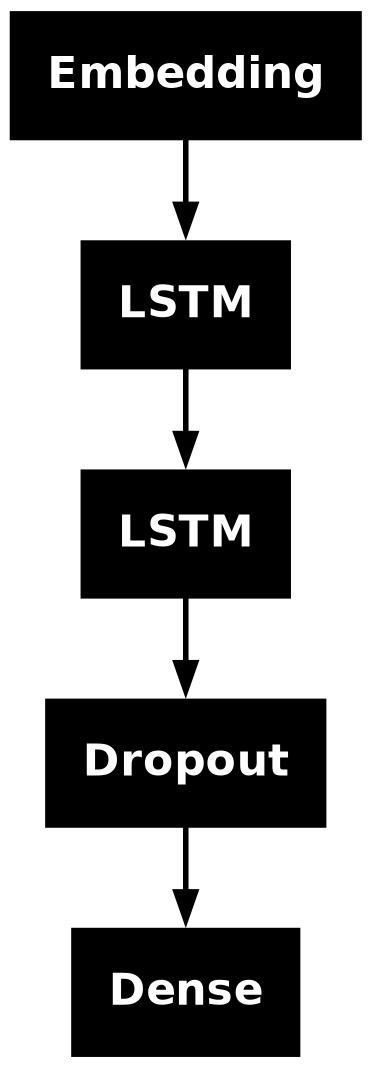

In [71]:
plot_model(model_word_generation,'/kaggle/working/model_word_gen.png')

## Test word based model based on RNN and LSTM


In [72]:
test_prediction_random_word_based_model_gen(model_word_generation)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
Predicted index is out of range. Continuing with the next word.
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
Predicted index is out of range. Continuing with the next word.
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
Predicted index is out of range. Continuing with the next word.
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
Predicted index is out of range. Continuing with the next word.
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
Predicted index is out of range. Continuing with the next word.
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
Predicted index is out of range. Continuing with the next word.
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
Predicted index is out of range. Continuing with the next word.
1/1 ━━━━━━━━━━━━━━━━

['version',
 'continually',
 'prohibitively',
 'codex',
 'hard',
 'unlikely',
 'action',
 'principle',
 'room',
 'time',
 'stock',
 'great']

In [82]:
test_prediction_random_word_based_model_gen(RNN_model_word_generation)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
Predicted index is out of range. Continuing with the next word.
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
Predicted index is out of range. Continuing with the next word.
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
Predicted index is out of range. Continuing with the next word.
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
Predicted index is out of range. Continuing with the next word.
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
Predicted index is out of range. Continuing with the next word.
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
Predicted index is out of range. Continuing with the next word.
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
Predicted index is out of range. Continuing with the next word.
1/1 ━━━━━━━━━━━━━━━━

['find',
 'arcade',
 'wikitext',
 'network',
 'weather',
 'hyper',
 'generally',
 'usually',
 '175b']

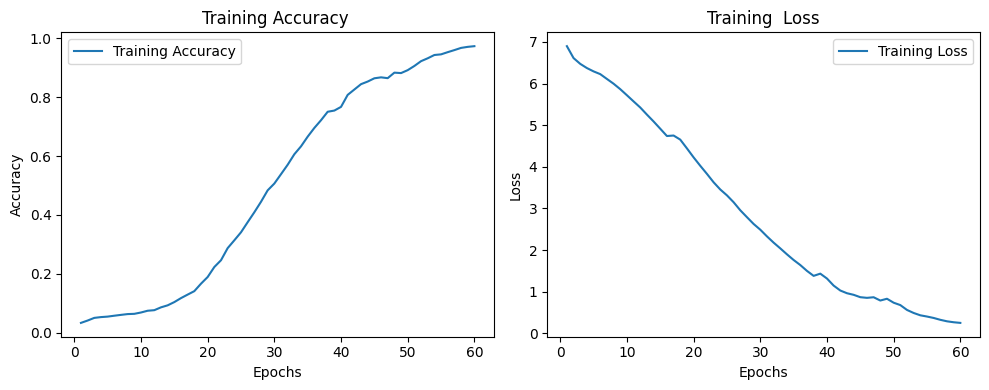

In [56]:
plot_training_history(history_LSTM)

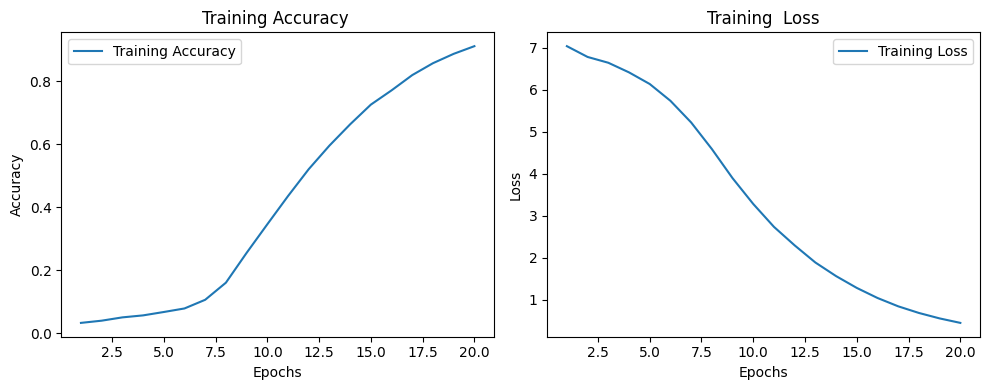

In [73]:
plot_training_history(history_RNN_word_based)